Cleaned ILI data for a specific year (2022) has been extracted from Satvinder's compiled data-set. This has been spatial joined with that year's pipe line data.

Now we can finally compare it with the EC_LOF numbers, by matching the correct pipeline segments.

In [2]:
# Plotting and math imports
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set(style="darkgrid")

import pandas as pd

from datetime import datetime
from typing import List, Optional, Dict

# SQL-related imports

import sqlalchemy
from sqlalchemy import (
    create_engine,
    MetaData,
    Table,
    inspect,
    select,
    cast,
    Float,
    func
)

# Load the cleaned ILI data

In [3]:
ILI_2022_joins_pipeline_filename = r"C:\Users\A1YU\OneDrive - PGE\Documents\code\ModelPerformance\processed_data\cleaned_ILI_2022_joins_Pipesegment_linear.csv"
ILI_2022_joins_pipeline = pd.read_csv(ILI_2022_joins_pipeline_filename, low_memory=False)

In [4]:
ILI_2022_joins_pipeline.columns.values

array(['FID', 'OBJECTID_1', 'FID_1', 'Vendor', 'Source', 'Route',
       'Route_NoPr', 'MP1', 'MP2', 'Year', 'ILI_Projec', 'ML_Survey',
       'Alignment', 'Joint___US', 'ILI_Survey', 'Joint_Leng',
       'From_U_S_G', 'To_D_S_GW', 'Identifica', 'Comment', 'Tool_Speed',
       'WT__in_', 'SMYS__PSI_', 'MAOP__PSI_', 'OD__in_', 'Longseam_V',
       'Seam_Pos_', 'Depth____', 'Depth___wi', 'OD_Reducti', 'Length__in',
       'Width__in_', 'O_clock', 'Internal', 'Bend_Radiu', 'Bend_Angle',
       'Bend_Direc', 'POF_Catego', 'Associated', 'Anomaly_ID',
       'Estimated', 'Pf_MAOP', 'Pf___with', 'Pf__MAOP', 'TotalBend',
       'Bend___Ver', 'Bend___Hor', 'Internal_D', 'External_D', 'Easting',
       'Northing', 'Latitude', 'Longitude', 'Elevation', 'U_S_Refere',
       'Dist__To_U', 'D_S_Refere', 'Dist__To_D', 'ILI_Vendor',
       'PG_E_Stati', 'OBJECTID', 'Id', 'EffectiveS', 'PipeManufa',
       'PipeOutsid', 'PipeWallTh', 'SMYS', 'PipeGradeD', 'PipeMateri',
       'PipeRepair', 'PipeSeamDo'

Note that the column names here are cut off and/or not formatted exactly. This is due to the different file saving process:
1. ILI data was loaded into pandas with Python, the rows corresponding to the year of 2022 taken out, then saved into a csv file. This process has the headers correct.
2. The cleaned ILI data for 2022 is then loaded into ArcMap for spatial join. When ArcMap loads the csv file, the header values get screwed up due to string processing.
3. After the cleaned ILI data and the pipeline data are spatial-joined in ArcMap, the resulting attrbiutes table are saved as csv again -- the header values are still screwed up.

Fortunately, we know what the column names need to be, and can correct them later.

# Load the MarinerDB 2022 EC_LOF table into pandas

In [5]:
server = "tsitinfdbsws010"
database = "MarinerDB_2022"
driver = "ODBC+Driver+17+for+SQL+Server"
url = f"mssql+pyodbc://{server}/{database}?trusted_connection=yes&driver={driver}"
engine = sqlalchemy.create_engine(url)
connection = engine.connect()

In [6]:
url

'mssql+pyodbc://tsitinfdbsws010/MarinerDB_2022?trusted_connection=yes&driver=ODBC+Driver+17+for+SQL+Server'

In [55]:
# The available table names here aren't the same as the one connected through arc map...
inspector = inspect(engine)
table_names = inspector.get_table_names()
table_names

['A_Form',
 'A_Form_CoverDepth',
 'ACAnnualPrecip',
 'ACDryChlorideDep',
 'ACSpans',
 'acspans_stage1_scc',
 'acspans_stage1_tpd',
 'ACSulfurDioxDep',
 'ACVaults',
 'anaRiskScores_2022',
 'anariskscores_2022_bk041023',
 'anaRiskScores_LOF_COF_2022',
 'anaRiskScores_pipe',
 'anaWAP_IDevents',
 'ArcFaultHistory',
 'Assessment_History',
 'assessment_history_bk110422',
 'Assessment_History_Cons',
 'Assessment_History_ILI',
 'Assessment_History_Manu',
 'assessment_plan',
 'assessment_plan_bk090922',
 'assessment_plan_stage1_ec',
 'assessment_plan_stage1_ic',
 'assessment_plan_stage1_scc',
 'AxialSCCLeak',
 'axialsccleak_stage1',
 'Bend',
 'bend_2022',
 'bend_bk0712',
 'bend_dups',
 'buffersize',
 'CA_2023_05',
 'CA_Categories',
 'Carefacility_IOC',
 'carefacility_ioc_tmp120122',
 'CASING',
 'casing_stage1',
 'CasingRawData',
 'Centerline_Per_Series',
 'Centerline_PIR',
 'classarea',
 'classarea_tmp101722',
 'classarea_upd101722',
 'coating',
 'Coating_assume_type',
 'Coating_Condition',
 'c

In [8]:
metadata_obj = MetaData()  # Why do I need this thing again...?
Table_EC_Risk_LOF = Table("EC_Risk_LOF", metadata_obj, autoload_with=engine)

In [74]:
with engine.connect() as conn:
    result = conn.execute(
        select(func.count()).select_from(Table_EC_Risk_LOF)
    ).fetchall()

In [75]:
result

[(900650,)]

In [9]:
# Find rows for which ILI completion date is in 2022
threshold_date = datetime(2022, 1, 1)
query = select(Table_EC_Risk_LOF).where(Table_EC_Risk_LOF.c.ILI_Completion_Date > threshold_date)
with engine.connect() as connection:
    LOF_with_ILI_in_2022 = connection.execute(query).fetchall()

In [10]:
# What does the first entry look like?
LOF_with_ILI_in_2022[0]._mapping

{'sortid': 316529, 'route': '1202-16', 'beginstationseriesid': '36339', 'beginstationnum': 17504.4, 'endstationseriesid': '36339', 'endstationnum': 17504.600000000002, 'Mainline_Coating_Type': 'H', 'Dry_Chloride_Deposition': 0.6200000047683716, 'Third_Party_Liquid_Proximity': None, 'Third_Party_Gas_Proximity': None, 'Lack_Casing_Test_Facilities': None, 'Casing': None, 'Annual_Precipitation': 32.77000045776367, 'ILI_Assessment_Method': 'ILI', 'ILI_Completion_Date': datetime.datetime(2022, 3, 28, 0, 0), 'Soil_Type': 'L', 'Soil_Resistivity': None, 'Foreign_Line_Crossing': None, 'Percent_Wall_Loss': Decimal('37.60'), 'Reassessment_Interval': Decimal('7'), 'Direct_Examination': None, 'Hydrotest_Completion_Date': None, 'Span_Prioritization': None, 'Span_Support': None, 'Span_Condition': None, 'Vault_Condition': None, 'Feature_Type': 'PIPE', 'PFL_Feature_Num': '147.00000', 'Manufacture_Date': datetime.datetime(1953, 8, 8, 0, 0), 'Pipe_Material': 'STL', 'Seam_Type_Assumed': 'Assumptions Calcul

In [11]:
with engine.connect() as connection:
    row_counts = connection.execute(
        select(func.count()).select_from(Table_EC_Risk_LOF)
    ).fetchall()[0][0]

In [12]:
print(
    f"For 2022, EC_LOF was calculated for {row_counts} pipe segments, "
    f"{len(LOF_with_ILI_in_2022)} pipe segments had ILI data available, "
    f"which is {len(LOF_with_ILI_in_2022) / row_counts * 100:.3f}%"
)

For 2022, EC_LOF was calculated for 900650 pipe segments, 24803 pipe segments had ILI data available, which is 2.754%


In [13]:
# Push the entire table into pandas dataframe
df_EC_Risk_LOF_with_ILI_in_2022 = pd.DataFrame(LOF_with_ILI_in_2022, columns=LOF_with_ILI_in_2022[0]._mapping.keys())

In [14]:
df_EC_Risk_LOF_with_ILI_in_2022.columns.values

array(['sortid', 'route', 'beginstationseriesid', 'beginstationnum',
       'endstationseriesid', 'endstationnum', 'Mainline_Coating_Type',
       'Dry_Chloride_Deposition', 'Third_Party_Liquid_Proximity',
       'Third_Party_Gas_Proximity', 'Lack_Casing_Test_Facilities',
       'Casing', 'Annual_Precipitation', 'ILI_Assessment_Method',
       'ILI_Completion_Date', 'Soil_Type', 'Soil_Resistivity',
       'Foreign_Line_Crossing', 'Percent_Wall_Loss',
       'Reassessment_Interval', 'Direct_Examination',
       'Hydrotest_Completion_Date', 'Span_Prioritization', 'Span_Support',
       'Span_Condition', 'Vault_Condition', 'Feature_Type',
       'PFL_Feature_Num', 'Manufacture_Date', 'Pipe_Material',
       'Seam_Type_Assumed', 'Seam_Type', 'Install_Date',
       'ECDA_Length_of_Mon', 'ECDA_Length_of_Sched', 'ECDA_Length_of_Imm',
       'ECDA_Project_Length', 'ECDA_Wall_Loss_GTE50',
       'ECDA_Wall_Loss_GTE40LT50', 'ECDA_Wall_Loss_GTE30LT40',
       'ECDA_Wall_Loss_GTE20LT30', 'ECDA_Num

In [15]:
(df_EC_Risk_LOF_with_ILI_in_2022["ILI_Completion_Date"] >= threshold_date).all()

True

# Match the ILI data with the EC_LOF table, pased on the stationing

Procedures to match dynamic pipe segments based on stationing, from Jackson:

> The failure pressure table has columns like "route", "beginstationnum", "endstationnum", "beginstationseriesid" [...] "you want to check if" SeriesID = beginstationseriesi"d and stationing between" beginstationnu"m and" endstationnu"m The interval type is closed and open..

In [16]:
# First fix the spatial joined ILI dataframe's headers..
ILI_2022_joins_pipeline.columns.values

array(['FID', 'OBJECTID_1', 'FID_1', 'Vendor', 'Source', 'Route',
       'Route_NoPr', 'MP1', 'MP2', 'Year', 'ILI_Projec', 'ML_Survey',
       'Alignment', 'Joint___US', 'ILI_Survey', 'Joint_Leng',
       'From_U_S_G', 'To_D_S_GW', 'Identifica', 'Comment', 'Tool_Speed',
       'WT__in_', 'SMYS__PSI_', 'MAOP__PSI_', 'OD__in_', 'Longseam_V',
       'Seam_Pos_', 'Depth____', 'Depth___wi', 'OD_Reducti', 'Length__in',
       'Width__in_', 'O_clock', 'Internal', 'Bend_Radiu', 'Bend_Angle',
       'Bend_Direc', 'POF_Catego', 'Associated', 'Anomaly_ID',
       'Estimated', 'Pf_MAOP', 'Pf___with', 'Pf__MAOP', 'TotalBend',
       'Bend___Ver', 'Bend___Hor', 'Internal_D', 'External_D', 'Easting',
       'Northing', 'Latitude', 'Longitude', 'Elevation', 'U_S_Refere',
       'Dist__To_U', 'D_S_Refere', 'Dist__To_D', 'ILI_Vendor',
       'PG_E_Stati', 'OBJECTID', 'Id', 'EffectiveS', 'PipeManufa',
       'PipeOutsid', 'PipeWallTh', 'SMYS', 'PipeGradeD', 'PipeMateri',
       'PipeRepair', 'PipeSeamDo'

In [17]:
# Replace the column names with the ones present in the EC_LOF table:
#
# ['route', 'beginstationseriesid', 'beginstationnum', 'endstationseriesid', 'endstationnum']
# Note that the column order is perserved through spatial join, saving csv, and loading csv into pandas.

# TODO: This needs to be automated better -- for example, standardize captalization of the letters...

ILI_2022_joins_pipeline.rename(
    columns={
        "Route": "route",
        "BeginStati": "beginstationseriesid",
        "BeginSta_1": "beginstationnum",
        "EndStation": "endstationseriesid",
        "EndStati_1": "endstationnum",
    },
    inplace=True
)

In [18]:
print(f"There are a total of {len(ILI_2022_joins_pipeline)} defects, but only {len(df_EC_Risk_LOF_with_ILI_in_2022)} dynamic pipe segments")

There are a total of 111667 defects, but only 24803 dynamic pipe segments


We will create a dictionary mapping each row of the `df_EC_Risk_LOF..` table to row(s) in the ILI anomaly table. But check matching critiera first..

## `route` matching

In [19]:
# Risk table
np.unique(df_EC_Risk_LOF_with_ILI_in_2022["route"])

array(['021H', '021H_U', '0617-06', '0617-14', '105B', '109', '114',
       '118A', '118B_U', '1202-16', '1202-17', '1202-21', '1209-01',
       '132', '138', '138C', '173-8', '2408-05', '300B', '301G', '310',
       '400', 'DF8958', 'STUB11090', 'STUB14127', 'STUB14492',
       'STUB14960', 'STUB22192', 'STUB23250', 'STUB23337', 'STUB23389',
       'STUB24129', 'STUB26621', 'STUB8918', 'X23148', 'X23263'],
      dtype=object)

In [20]:
# ILI data
np.unique(ILI_2022_joins_pipeline["route"])

array(['DFM-1209-01', 'L-021H', 'L-057B', 'L-0617-06', 'L-101', 'L-105B',
       'L-109', 'L-111A', 'L-114', 'L-118B', 'L-119A', 'L-138', 'L-138C',
       'L-138E', 'L-148', 'L-153', 'L-173', 'L-300B', 'L-301G', 'L-310',
       'L-401'], dtype=object)

In [21]:
# ILI data's route are in better shape..format it to match risk tables..
np.array([x.split("-", 1)[1] for x in np.unique(ILI_2022_joins_pipeline["route"])])

array(['1209-01', '021H', '057B', '0617-06', '101', '105B', '109', '111A',
       '114', '118B', '119A', '138', '138C', '138E', '148', '153', '173',
       '300B', '301G', '310', '401'], dtype='<U7')

__Issue 1__: This is very strange... the pipeline segments that ILI completion in 2022 contains routes that are not present in 2022's ILI data..

### Construct a mapping of the routes from the risk table to ILI data

In [22]:
unique_risk_routes = np.unique(df_EC_Risk_LOF_with_ILI_in_2022["route"])
unique_ILI_routes = np.unique(ILI_2022_joins_pipeline["route"])
unique_ILI_routes_no_prefix = np.array([x.split("-", 1)[1] for x in unique_ILI_routes])

RISK_ROUTE_TO_ILI_ROUTE = {key : None for key in unique_risk_routes}
for (i, ILI_route_str) in enumerate(unique_ILI_routes_no_prefix):
    for risk_route in unique_risk_routes:
        if ILI_route_str in risk_route:
            RISK_ROUTE_TO_ILI_ROUTE[risk_route] = unique_ILI_routes[i]
            continue

In [23]:
RISK_ROUTE_TO_ILI_ROUTE

{'021H': 'L-021H',
 '021H_U': 'L-021H',
 '0617-06': 'L-0617-06',
 '0617-14': None,
 '105B': 'L-105B',
 '109': 'L-109',
 '114': 'L-114',
 '118A': None,
 '118B_U': 'L-118B',
 '1202-16': None,
 '1202-17': None,
 '1202-21': None,
 '1209-01': 'DFM-1209-01',
 '132': None,
 '138': 'L-138',
 '138C': 'L-138C',
 '173-8': 'L-173',
 '2408-05': None,
 '300B': 'L-300B',
 '301G': 'L-301G',
 '310': 'L-310',
 '400': None,
 'DF8958': None,
 'STUB11090': 'L-109',
 'STUB14127': None,
 'STUB14492': None,
 'STUB14960': None,
 'STUB22192': None,
 'STUB23250': None,
 'STUB23337': None,
 'STUB23389': None,
 'STUB24129': None,
 'STUB26621': None,
 'STUB8918': None,
 'X23148': 'L-148',
 'X23263': None}

## `beginstationseriesid` and `endstationseriesid` matching

In [24]:
# Risk table
print(np.unique(df_EC_Risk_LOF_with_ILI_in_2022["beginstationseriesid"]))

# Convert it into int
df_EC_Risk_LOF_with_ILI_in_2022["beginstationseriesid"] = df_EC_Risk_LOF_with_ILI_in_2022["beginstationseriesid"].astype(int)
print(np.unique(df_EC_Risk_LOF_with_ILI_in_2022["beginstationseriesid"]))


['21367' '21804' '22271' '23803' '28207' '28402' '29133' '31024' '31930'
 '32189' '33222' '34251' '34364' '34613' '35530' '35611' '36339' '36996'
 '37161' '37239' '37363' '37731' '37775' '38008' '38072' '38122' '39228'
 '39887' '40082' '40985' '41017' '41032' '42094' '42579' '43143' '43668'
 '44413' '44549' '44654' '52218' '53158' '65151']
[21367 21804 22271 23803 28207 28402 29133 31024 31930 32189 33222 34251
 34364 34613 35530 35611 36339 36996 37161 37239 37363 37731 37775 38008
 38072 38122 39228 39887 40082 40985 41017 41032 42094 42579 43143 43668
 44413 44549 44654 52218 53158 65151]


In [25]:
# np.unique(df_EC_Risk_LOF_with_ILI_in_2022["endstationseriesid"])
df_EC_Risk_LOF_with_ILI_in_2022["endstationseriesid"] = df_EC_Risk_LOF_with_ILI_in_2022["endstationseriesid"].astype(int)
np.unique(df_EC_Risk_LOF_with_ILI_in_2022["endstationseriesid"])

array([21367, 21804, 22271, 23803, 28207, 28402, 29133, 31024, 31930,
       32189, 33222, 34251, 34364, 34613, 35530, 35611, 36339, 36996,
       37161, 37239, 37363, 37731, 37775, 38008, 38072, 38122, 39228,
       39887, 40082, 40985, 41017, 41032, 42094, 42579, 43143, 43668,
       44413, 44549, 44654, 52218, 53158, 65151])

In [26]:
# Each segment's begin and end series id should be the same!
(df_EC_Risk_LOF_with_ILI_in_2022["beginstationseriesid"] == df_EC_Risk_LOF_with_ILI_in_2022["endstationseriesid"]).all()

True

In [27]:
# ILI data
np.unique(ILI_2022_joins_pipeline["beginstationseriesid"])

array([ 5409,  6030,  6033,  6135,  6770,  6781,  6803,  6812,  6840,
        7367,  7368,  9729,  9771, 10697, 10903, 11146, 12393, 12484,
       13977, 13978, 13983, 13984, 14125, 14289, 14317, 17550, 17650,
       18421, 19963, 20031, 20767, 20792, 21278, 21367, 22006, 22030,
       22245, 22271, 22398, 22508, 22762, 22859, 23126, 23177, 23658,
       23803, 24893, 25964, 25967, 26092, 26130, 26131, 26835, 28185,
       28247, 28293, 28402, 28468, 28555, 28606, 28663, 28730, 28743,
       28763, 28786, 28830, 28839, 28908, 28921, 28931, 29262, 29275,
       29470, 29629, 29742, 29760, 29837, 30043, 30259, 30262, 30291,
       30357, 30366, 30442, 30563, 30855, 30965, 31024, 31319, 31715,
       31930, 32004, 32118, 32189, 32195, 32204, 32232, 32311, 32510,
       32930, 33030, 33097, 33222, 33243, 33339, 33749, 33963, 33977,
       33998, 34059, 34116, 34247, 34251, 34364, 34493, 34583, 34613,
       34674, 34693, 34817, 34871, 34926, 34966, 35314, 35316, 35530,
       35581, 35610,

In [28]:
(ILI_2022_joins_pipeline["beginstationseriesid"] == ILI_2022_joins_pipeline["endstationseriesid"]).all()

True

## `beginstationnum` and `endstationum` matching

In [29]:
# Risk table
np.unique(df_EC_Risk_LOF_with_ILI_in_2022["beginstationnum"])

array([0.0000000e+00, 2.0000000e-02, 4.0000000e-02, ..., 2.4126539e+06,
       2.4126610e+06, 2.4126630e+06])

In [30]:
# Risk table
np.unique(df_EC_Risk_LOF_with_ILI_in_2022["endstationnum"])

array([2.00000000e-02, 4.00000000e-02, 1.40000000e-01, ...,
       2.41266100e+06, 2.41266300e+06, 2.41266301e+06])

In [31]:
# endstationum should be bigger than beginstationum
(df_EC_Risk_LOF_with_ILI_in_2022["endstationnum"] > df_EC_Risk_LOF_with_ILI_in_2022["beginstationnum"]).all()

True

In [32]:
# ILI data
np.unique(ILI_2022_joins_pipeline["beginstationnum"])

array([0.0000000e+00, 3.0000000e-02, 2.0000000e-01, ..., 2.2639250e+06,
       2.2639316e+06, 2.2639374e+06])

In [33]:
np.unique(ILI_2022_joins_pipeline["endstationnum"])

array([2.0000000e-01, 3.0000000e-01, 4.0000000e-01, ..., 2.2639300e+06,
       2.2639374e+06, 2.2639418e+06])

In [34]:
(ILI_2022_joins_pipeline["endstationnum"] > ILI_2022_joins_pipeline["beginstationnum"]).all()

True

# Now we create a stationing map

In [35]:
DICT_SEGMENTS_TO_ANOMALY = {row_num: None for row_num in range(len(df_EC_Risk_LOF_with_ILI_in_2022))}

In [36]:
found_matches = 0

for row_num in range(len(df_EC_Risk_LOF_with_ILI_in_2022)):
    risk_route = df_EC_Risk_LOF_with_ILI_in_2022["route"][row_num]
    if RISK_ROUTE_TO_ILI_ROUTE[risk_route] is None:
        continue
    station_id = df_EC_Risk_LOF_with_ILI_in_2022["beginstationseriesid"][row_num]
    begin_station_num = df_EC_Risk_LOF_with_ILI_in_2022["beginstationnum"][row_num]
    end_station_num = df_EC_Risk_LOF_with_ILI_in_2022["endstationnum"][row_num]
    # now look into the ILI data frame
    same_route = ILI_2022_joins_pipeline["route"] == RISK_ROUTE_TO_ILI_ROUTE[risk_route]
    same_station = ILI_2022_joins_pipeline["beginstationseriesid"] == station_id
    ge_begin_station_num = ILI_2022_joins_pipeline["beginstationnum"] >= begin_station_num
    lt_end_station_num = ILI_2022_joins_pipeline["endstationnum"] < end_station_num
    indices = ILI_2022_joins_pipeline.index[same_route & same_station & ge_begin_station_num & lt_end_station_num].tolist()
    if len(indices) > 0:
        found_matches += 1
    DICT_SEGMENTS_TO_ANOMALY[row_num] = indices    

In [37]:
DICT_SEGMENTS_TO_ANOMALY_MATCHING = {k: v for k, v in DICT_SEGMENTS_TO_ANOMALY.items() if v and len(v) > 0}

In [38]:
sum([len(v) for v in list(DICT_SEGMENTS_TO_ANOMALY_MATCHING.values())])

120

We can only map 120 of the ILI anomalies?!

In [39]:
# Inspect a matching pipe segment
matching_rows = list(DICT_SEGMENTS_TO_ANOMALY_MATCHING.keys())
df_EC_Risk_LOF_with_ILI_in_2022.iloc[matching_rows[0:2]][["route", "beginstationseriesid", "beginstationnum", "endstationseriesid", "endstationnum"]]

,route,beginstationseriesid,beginstationnum,endstationseriesid,endstationnum
1790,300B,37161,7199.9,37161,7300.9
7275,301G,44549,83659.5,44549,83661.4


In [40]:
ili_rows = []
for i in matching_rows[0:2]:
    ili_rows.extend(DICT_SEGMENTS_TO_ANOMALY_MATCHING[i])
ILI_2022_joins_pipeline.iloc[ili_rows][["route", "beginstationseriesid", "beginstationnum", "endstationseriesid", "endstationnum"]]

,route,beginstationseriesid,beginstationnum,endstationseriesid,endstationnum
57153,L-300B,37161,7199.9,37161,7300.9
57154,L-300B,37161,7199.9,37161,7300.9
57155,L-300B,37161,7199.9,37161,7300.9
57156,L-300B,37161,7199.9,37161,7300.9
57157,L-300B,37161,7199.9,37161,7300.9
57158,L-300B,37161,7199.9,37161,7300.9
57159,L-300B,37161,7199.9,37161,7300.9
57160,L-300B,37161,7199.9,37161,7300.9
57161,L-300B,37161,7199.9,37161,7300.9
57162,L-300B,37161,7199.9,37161,7300.9


__Issue 2__: The matching pipeline segments look alright...but most of the anomalies are not matched anywhere. Why and what do I do next?

# Look at the EC_LOF and failure pressure?

In [41]:
ILI_2022_joins_pipeline.columns.values

array(['FID', 'OBJECTID_1', 'FID_1', 'Vendor', 'Source', 'route',
       'Route_NoPr', 'MP1', 'MP2', 'Year', 'ILI_Projec', 'ML_Survey',
       'Alignment', 'Joint___US', 'ILI_Survey', 'Joint_Leng',
       'From_U_S_G', 'To_D_S_GW', 'Identifica', 'Comment', 'Tool_Speed',
       'WT__in_', 'SMYS__PSI_', 'MAOP__PSI_', 'OD__in_', 'Longseam_V',
       'Seam_Pos_', 'Depth____', 'Depth___wi', 'OD_Reducti', 'Length__in',
       'Width__in_', 'O_clock', 'Internal', 'Bend_Radiu', 'Bend_Angle',
       'Bend_Direc', 'POF_Catego', 'Associated', 'Anomaly_ID',
       'Estimated', 'Pf_MAOP', 'Pf___with', 'Pf__MAOP', 'TotalBend',
       'Bend___Ver', 'Bend___Hor', 'Internal_D', 'External_D', 'Easting',
       'Northing', 'Latitude', 'Longitude', 'Elevation', 'U_S_Refere',
       'Dist__To_U', 'D_S_Refere', 'Dist__To_D', 'ILI_Vendor',
       'PG_E_Stati', 'OBJECTID', 'Id', 'EffectiveS', 'PipeManufa',
       'PipeOutsid', 'PipeWallTh', 'SMYS', 'PipeGradeD', 'PipeMateri',
       'PipeRepair', 'PipeSeamDo'

In [42]:
# FP_fields = ['Estimated Failure Pressure (Pf) ', 'Pf/MAOP', 'Pf* (with tool tolerances)', 'Pf*/MAOP']

ILI_2022_joins_pipeline.rename(
    columns={
        "Estimated": "Estimated Failure Pressure (Pf)",
        "Pf_MAOP": "Pf/MAOP",
        "Pf___with": "Pf* (with tool tolerances)",
        "Pf__MAOP": "Pf*/MAOP",
    },
    inplace=True
)
FP_fields = ['Estimated Failure Pressure (Pf)', 'Pf/MAOP', 'Pf* (with tool tolerances)', 'Pf*/MAOP']

The actual ILI data doesn't have failure pressure equal to 0 (that means pipe will fail by default), this is a data parsing error. Replace them with nan.

In [43]:
ILI_2022_joins_pipeline[FP_fields] = ILI_2022_joins_pipeline[FP_fields].replace(0, np.nan)

(array([5.0000e+00, 1.4575e+04, 6.2720e+03, 6.6530e+03, 3.4270e+03,
        7.0700e+02, 1.3000e+02, 5.4000e+01, 1.0400e+02, 5.4000e+02]),
 array([0.23 , 1.173, 2.116, 3.059, 4.002, 4.945, 5.888, 6.831, 7.774,
        8.717, 9.66 ]),
 <BarContainer object of 10 artists>)

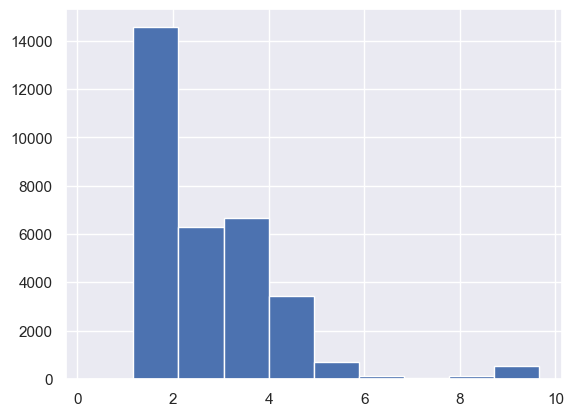

In [44]:
plt.hist(ILI_2022_joins_pipeline["Pf*/MAOP"])

In [45]:
# match ec_lof_leak and/or ec_lof_rupture with the failure pressure
ec_lof_leak = df_EC_Risk_LOF_with_ILI_in_2022.iloc[matching_rows]["EC_LOF_Leak"]
ec_lof_rupture = df_EC_Risk_LOF_with_ILI_in_2022.iloc[matching_rows]["EC_LOF_Rupture"]

In [46]:
np.mean(ILI_2022_joins_pipeline.iloc[DICT_SEGMENTS_TO_ANOMALY[matching_rows[0]]]["Pf/MAOP"])

1.706666666666667

In [47]:
def get_failure_pressure_from_matching_rows(
    dict_segments_to_anomaly_matching: Dict[int, Optional[List]],
    ili_df: pd.DataFrame,
    failure_pressure_type: str = "Pf*/MAOP",
    anomaly_aggregation: str = "max",
) -> np.ndarray:
    output = []
    for idx_route, idx_anomaly in dict_segments_to_anomaly_matching.items():
        values = ili_df.iloc[idx_anomaly][failure_pressure_type]
        if all(np.isnan(values)):
            output.append(np.nan)
            continue            
        if anomaly_aggregation == "max":
            output.append(np.nanmax(values))
        elif anomaly_aggregation == "mean":
            output.append(np.nanmean(values))
        elif anomaly_aggregation == "min":
            output.append(np.nanmin(values))
    assert len(output) == len(dict_segments_to_anomaly_matching)
    return np.array(output)

In [48]:
adj_pf_maop = get_failure_pressure_from_matching_rows(
    DICT_SEGMENTS_TO_ANOMALY_MATCHING,
    ILI_2022_joins_pipeline,
    failure_pressure_type="Pf*/MAOP",
    anomaly_aggregation="mean",
)

Higher failure pressure means the pipe is stronger, meaning LOF should be lower. So we expect to see an inverse relationship between these values.

In [49]:
np.concatenate([ec_lof_leak.values.reshape(-1, 1), adj_pf_maop.reshape(-1, 1)], axis=1)

array([[0.00000000e+00, 1.70166667e+00],
       [2.93455817e-08,            nan],
       [0.00000000e+00,            nan],
       [0.00000000e+00,            nan],
       [0.00000000e+00,            nan],
       [3.10033614e-08,            nan],
       [8.52074907e-08,            nan],
       [0.00000000e+00, 1.70200000e+00],
       [0.00000000e+00,            nan],
       [0.00000000e+00, 1.70000000e+00],
       [3.96294611e-08, 7.15000000e+00],
       [2.93455817e-08,            nan],
       [0.00000000e+00,            nan],
       [0.00000000e+00,            nan],
       [0.00000000e+00,            nan],
       [2.51572612e-08,            nan],
       [3.96294611e-08,            nan],
       [0.00000000e+00, 2.09000000e+00]])

Text(0, 0.5, 'Pf*/MAOP')

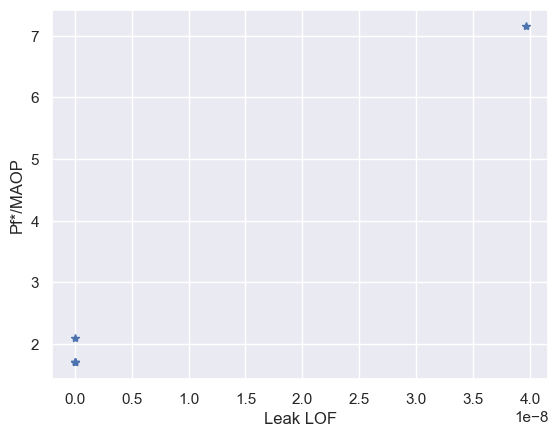

In [50]:
plt.plot(ec_lof_leak, adj_pf_maop, "*")
plt.xlabel("Leak LOF")
plt.ylabel("Pf*/MAOP")

Text(0, 0.5, 'Pf*/MAOP')

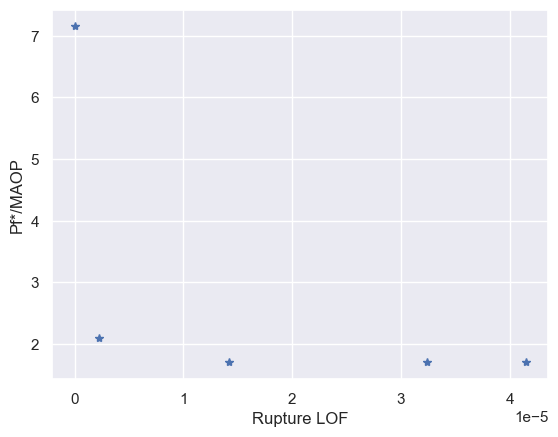

In [51]:
plt.plot(ec_lof_rupture, adj_pf_maop, "*")
plt.xlabel("Rupture LOF")
plt.ylabel("Pf*/MAOP")

The rupture LOF seems well correlated with Adjusted failure pressure...